# Slicing for CNN

In this notebook I will divide each scan in slices along the X axis. These slices will server as units of our data for modelling.

File configuration

In [1]:
# Adjust the frac parameter for loess smoothing
# to control the degree of smoothing applied to the scan data.
diff_dir = "../scandata/difference loess frac=0.20"

Libraries used:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

Let's load the pointclouds.

In [3]:
npy_files = [filename for filename in os.listdir(diff_dir) if filename.endswith(".npy")]
difference_point_clouds = [np.load(os.path.join(diff_dir, npy_file)) for npy_file in npy_files]

num_of_clouds = len(difference_point_clouds)
total_rows = 0

print(f"Loaded {num_of_clouds} difference point clouds.")

for i in range(num_of_clouds):
    print(f"Difference point cloud {npy_files[i]} shape: {difference_point_clouds[i].shape}")
    total_rows += difference_point_clouds[i].shape[0]
print(f"Total number of rows: {total_rows}")

Loaded 5 difference point clouds.
Difference point cloud 221111_144114__binary_onlylines114378to117271 loess frac=0.2_difference.npy shape: (5543532, 3)
Difference point cloud 221111_144114__binary_onlylines145900to148050 loess frac=0.2_difference.npy shape: (3786525, 3)
Difference point cloud 221111_144114__binary_onlylines25660to28100 loess frac=0.2_difference.npy shape: (3535680, 3)
Difference point cloud 221111_144114__binary_onlylines47178to50517 loess frac=0.2_difference.npy shape: (3414927, 3)
Difference point cloud 221111_144114__binary_onlylines86841to90142 loess frac=0.2_difference.npy shape: (4718054, 3)
Total number of rows: 20998718


In [4]:
# Function to convert point cloud slice to 2D image array
def slice_to_image(slice_points, x_range, y_range, resolution=1.0):
    """
    Convert a point cloud slice to a 2D image array.
    
    Parameters:
    - slice_points: array of shape (N, 3) with columns [X, Y, Z]
    - x_range: tuple (min_x, max_x) defining the X bounds
    - y_range: tuple (min_y, max_y) defining the Y bounds
    - resolution: pixel size (default 1.0 means 1 unit per pixel)
    
    Returns:
    - image: 2D array where X,Y coords map to image indices and Z values are pixel intensities
    - actual_x_range: actual X range used
    - actual_y_range: actual Y range used
    """
    if slice_points.shape[0] == 0:
        # Return empty image if no points
        img_width = int((x_range[1] - x_range[0]) / resolution) + 1
        img_height = int((y_range[1] - y_range[0]) / resolution) + 1
        return np.zeros((img_height, img_width)), x_range, y_range
    
    # Calculate image dimensions
    img_width = int((x_range[1] - x_range[0]) / resolution) + 1
    img_height = int((y_range[1] - y_range[0]) / resolution) + 1
    
    # Initialize image array
    image = np.zeros((img_height, img_width))
    count_array = np.zeros((img_height, img_width))  # For averaging overlapping points
    
    # Convert coordinates to image indices
    x_indices = ((slice_points[:, 0] - x_range[0]) / resolution).astype(int)
    y_indices = ((slice_points[:, 1] - y_range[0]) / resolution).astype(int)
    
    # Clip indices to valid range
    x_indices = np.clip(x_indices, 0, img_width - 1)
    y_indices = np.clip(y_indices, 0, img_height - 1)
    
    # Accumulate Z values at each pixel
    for i in range(len(slice_points)):
        image[y_indices[i], x_indices[i]] += slice_points[i, 2]
        count_array[y_indices[i], x_indices[i]] += 1
    
    # Average overlapping points
    mask = count_array > 0
    image[mask] = image[mask] / count_array[mask]
    
    return image, x_range, y_range

# Function to slice point clouds by x-coordinate and convert to images with consistent dimensions
def slice_pointcloud_to_images(point_cloud, slice_width=10, resolution=1.0, global_y_range=None):
    """
    Slice point cloud by X coordinate and convert each slice to 2D image.
    
    Parameters:
    - point_cloud: array of shape (N, 3) with columns [X, Y, Z]
    - slice_width: width of each slice along X axis
    - resolution: pixel resolution for the images
    - global_y_range: tuple (min_y, max_y) to use for all slices (for consistency)
    
    Returns:
    - images: list of 2D arrays (images)
    - starts: list of X coordinates where each slice starts
    - y_range: tuple (min_y, max_y) used for this point cloud
    """
    # Ensure shape is (N, 3)
    if point_cloud.shape[0] == 3 and point_cloud.shape[1] != 3:
        point_cloud = point_cloud.T
    
    # Use provided global Y range or calculate from this point cloud
    if global_y_range is None:
        y_min = point_cloud[:, 1].min()
        y_max = point_cloud[:, 1].max()
        y_range = (y_min, y_max)
    else:
        y_range = global_y_range
    
    x_coords = point_cloud[:, 0].astype(int)
    min_x = x_coords.min()
    max_x = x_coords.max()
    
    images = []
    starts = []
    
    for start_x in range(min_x, max_x + 1, slice_width):
        end_x = start_x + slice_width
        mask = (x_coords >= start_x) & (x_coords < end_x)
        slice_points = point_cloud[mask]
        
        # Always use the same x_range and y_range for consistent image size
        x_range = (start_x, start_x + slice_width - 1)
        image, _, _ = slice_to_image(slice_points, x_range, y_range, resolution)
        images.append(image)
        starts.append(start_x)
    
    return images, starts, y_range

# Define parameters first
resolution = 1.0  # 1 unit per pixel
slice_width = 10

# First pass: find global Y range across all point clouds
print("Finding global Y range across all point clouds...")
global_y_min = float('inf')
global_y_max = float('-inf')

for idx, pc in enumerate(difference_point_clouds):
    # Ensure shape is (N, 3)
    if pc.shape[0] == 3 and pc.shape[1] != 3:
        pc = pc.T
    
    y_min = pc[:, 1].min()
    y_max = pc[:, 1].max()
    global_y_min = min(global_y_min, y_min)
    global_y_max = max(global_y_max, y_max)
    print(f"Point cloud {idx}: Y range ({y_min:.2f}, {y_max:.2f})")

global_y_range = (global_y_min, global_y_max)
print(f"Global Y range: {global_y_range}")

# Calculate expected image dimensions
expected_height = int((global_y_max - global_y_min) / resolution) + 1
expected_width = int(slice_width / resolution)
expected_shape = (expected_height, expected_width)
print(f"Expected image shape: {expected_shape}")

Finding global Y range across all point clouds...
Point cloud 0: Y range (-219.89, 282.48)
Point cloud 1: Y range (-292.93, 178.96)
Point cloud 2: Y range (-123.97, 325.35)
Point cloud 3: Y range (-25.03, 342.37)
Point cloud 4: Y range (-310.66, 267.45)
Global Y range: (np.float64(-310.65673828125), np.float64(342.36572265625))
Expected image shape: (654, 10)


In [5]:
# Creating image slices each 10 units wide with consistent dimensions
all_image_slices = []
all_starts = []

resolution = 1.0  # 1 unit per pixel
slice_width = 10
print(f"Using resolution: {resolution} units per pixel")
print(f"Using slice width: {slice_width} units")
print(f"All images will have shape: {expected_shape}")

for idx, pc in enumerate(difference_point_clouds):
    images, starts, y_range = slice_pointcloud_to_images(
        pc, slice_width=slice_width, resolution=resolution, global_y_range=global_y_range
    )
    print(f"Point cloud {idx}: {len(images)} image slices")
    print(f"  Y range used: {y_range}")
    print(f"  Image shape: {images[0].shape if images else 'No images'}")
    
    # Verify all images have the same shape
    for i, image in enumerate(images):
        if image.shape != expected_shape:
            print(f"  WARNING: Slice {i} has shape {image.shape}, expected {expected_shape}")
        else:
            print(f"  Slice {i}: starts at X={starts[i]}, correct shape {image.shape}")
    
    all_image_slices.append(images)
    all_starts.append(starts)

print(f"All images should have shape: {expected_shape}")

Using resolution: 1.0 units per pixel
Using slice width: 10 units
All images will have shape: (654, 10)
Point cloud 0: 290 image slices
  Y range used: (np.float64(-310.65673828125), np.float64(342.36572265625))
  Image shape: (654, 10)
  Slice 0: starts at X=0, correct shape (654, 10)
  Slice 1: starts at X=10, correct shape (654, 10)
  Slice 2: starts at X=20, correct shape (654, 10)
  Slice 3: starts at X=30, correct shape (654, 10)
  Slice 4: starts at X=40, correct shape (654, 10)
  Slice 5: starts at X=50, correct shape (654, 10)
  Slice 6: starts at X=60, correct shape (654, 10)
  Slice 7: starts at X=70, correct shape (654, 10)
  Slice 8: starts at X=80, correct shape (654, 10)
  Slice 9: starts at X=90, correct shape (654, 10)
  Slice 10: starts at X=100, correct shape (654, 10)
  Slice 11: starts at X=110, correct shape (654, 10)
  Slice 12: starts at X=120, correct shape (654, 10)
  Slice 13: starts at X=130, correct shape (654, 10)
  Slice 14: starts at X=140, correct shape

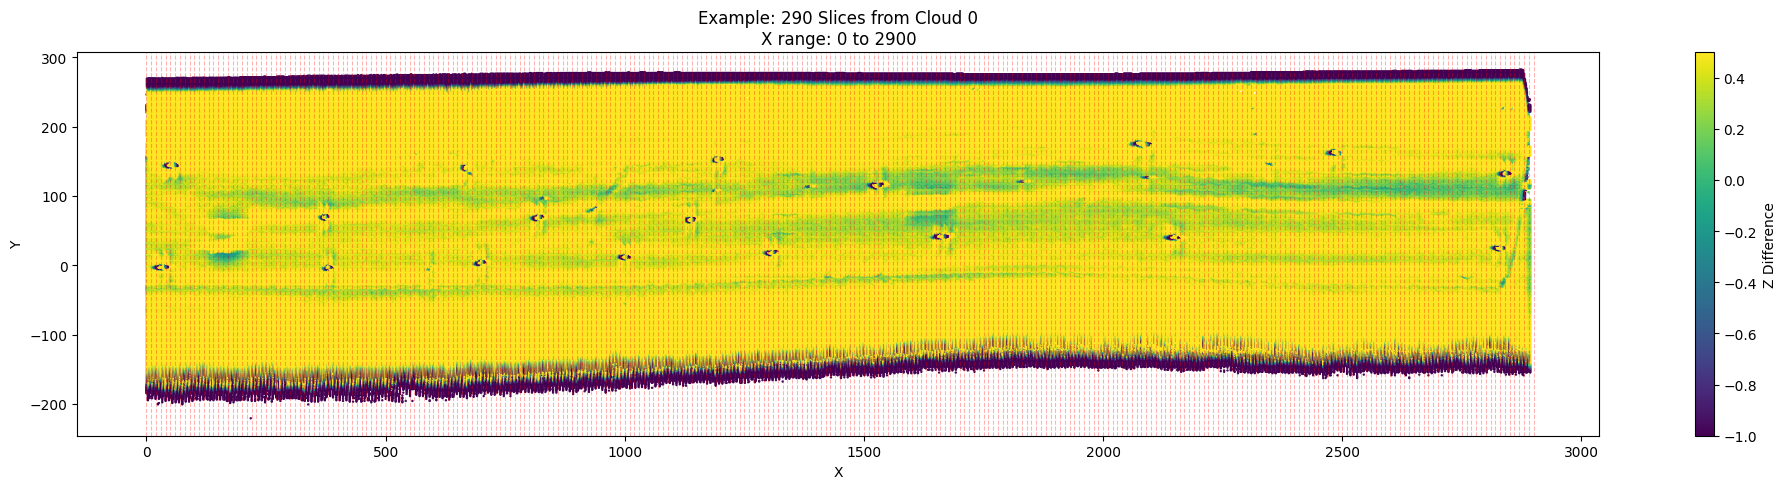

In [6]:
# Visualize one example of a sliced point cloud
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

# Show first cloud
cloud_idx = 0
images = all_image_slices[cloud_idx]
starts = all_starts[cloud_idx]
slices_to_show = len(images)

all_x = []
all_y = []
all_z = []

for slice_idx in range(min(slices_to_show, len(images))):
    image = images[slice_idx]
    start_x = starts[slice_idx]
    
    # Convert image back to point cloud format for scatter plot
    y_coords, x_coords = np.where(image != 0)  # Get non-zero pixel coordinates
    z_values = image[y_coords, x_coords]  # Get corresponding Z values
    
    # Convert pixel coordinates back to actual coordinates
    actual_x = x_coords + start_x
    actual_y = y_coords + global_y_min
    
    if len(z_values) > 0:
        all_x.extend(actual_x)
        all_y.extend(actual_y)
        all_z.extend(z_values)

if len(all_x) > 0:
    # Create scatter plot with Z-difference coloring using viridis
    sc = ax.scatter(all_x, all_y, c=all_z, s=0.5, cmap='viridis', vmin=-1, vmax=0.5)
    
    # Add colorbar for Z difference
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Z Difference')
    
    ax.set_title(f"Example: {min(slices_to_show, len(images))} Slices from Cloud {cloud_idx}\n"
                f"X range: {starts[0]} to {starts[min(slices_to_show, len(images))-1] + slice_width}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    # Add vertical lines to show slice boundaries
    for slice_idx in range(min(slices_to_show + 1, len(starts) + 1)):
        if slice_idx < len(starts):
            x_boundary = starts[slice_idx]
            ax.axvline(x=x_boundary, color='red', linestyle='--', alpha=0.3, linewidth=0.8)
        elif slice_idx == slices_to_show and slices_to_show <= len(starts):
            x_boundary = starts[slices_to_show-1] + slice_width
            ax.axvline(x=x_boundary, color='red', linestyle='--', alpha=0.3, linewidth=0.8)
else:
    ax.text(0.5, 0.5, 'No data in selected slices', 
           horizontalalignment='center', verticalalignment='center', 
           transform=ax.transAxes)
    ax.set_title("No data available")

plt.tight_layout()
plt.show()

In [7]:
# Normalize images to 0-1 range for better CNN training
def normalize_images(images, method='global'):
    """
    Normalize image intensities.
    
    Parameters:
    - images: list of 2D arrays
    - method: 'global' (normalize across all images) or 'individual' (normalize each image separately)
    
    Returns:
    - normalized_images: list of normalized 2D arrays
    - norm_params: normalization parameters for potential inverse transform
    """
    if method == 'global':
        # Find global min/max across all images
        all_values = np.concatenate([img.flatten() for img in images])
        global_min = all_values.min()
        global_max = all_values.max()
        
        normalized = []
        for img in images:
            if global_max > global_min:
                norm_img = (img - global_min) / (global_max - global_min)
            else:
                norm_img = np.zeros_like(img)
            normalized.append(norm_img)
        
        return normalized, {'method': 'global', 'min': global_min, 'max': global_max}
    
    elif method == 'individual':
        normalized = []
        norm_params = []
        
        for img in images:
            img_min = img.min()
            img_max = img.max()
            
            if img_max > img_min:
                norm_img = (img - img_min) / (img_max - img_min)
            else:
                norm_img = np.zeros_like(img)
            
            normalized.append(norm_img)
            norm_params.append({'min': img_min, 'max': img_max})
        
        return normalized, {'method': 'individual', 'params': norm_params}

# Normalize all image slices
all_normalized_slices = []
normalization_params = []

for cloud_idx, images in enumerate(all_image_slices):
    normalized, norm_params = normalize_images(images, method='global')
    all_normalized_slices.append(normalized)
    normalization_params.append(norm_params)
    print(f"Cloud {cloud_idx}: Normalized {len(normalized)} images")
    
    # Handle different parameter structures based on normalization method
    if norm_params['method'] == 'individual':
        # For individual normalization, show range of first and last images as example
        if len(norm_params['params']) > 0:
            first_params = norm_params['params'][0]
            last_params = norm_params['params'][-1]
            print(f"  First slice range: {first_params['min']:.4f} to {first_params['max']:.4f}")
            print(f"  Last slice range: {last_params['min']:.4f} to {last_params['max']:.4f}")
    else:
        # For global normalization
        print(f"  Normalization range: {norm_params['min']:.4f} to {norm_params['max']:.4f}")

Cloud 0: Normalized 290 images
  Normalization range: -37.4130 to 6.0607
Cloud 1: Normalized 216 images
  Normalization range: -53.5368 to 8.1785
Cloud 2: Normalized 245 images
  Normalization range: -12.4447 to 4.1178
Cloud 3: Normalized 334 images
  Normalization range: -4.7650 to 3.7165
Cloud 4: Normalized 331 images
  Normalization range: -38.7946 to 7.7218


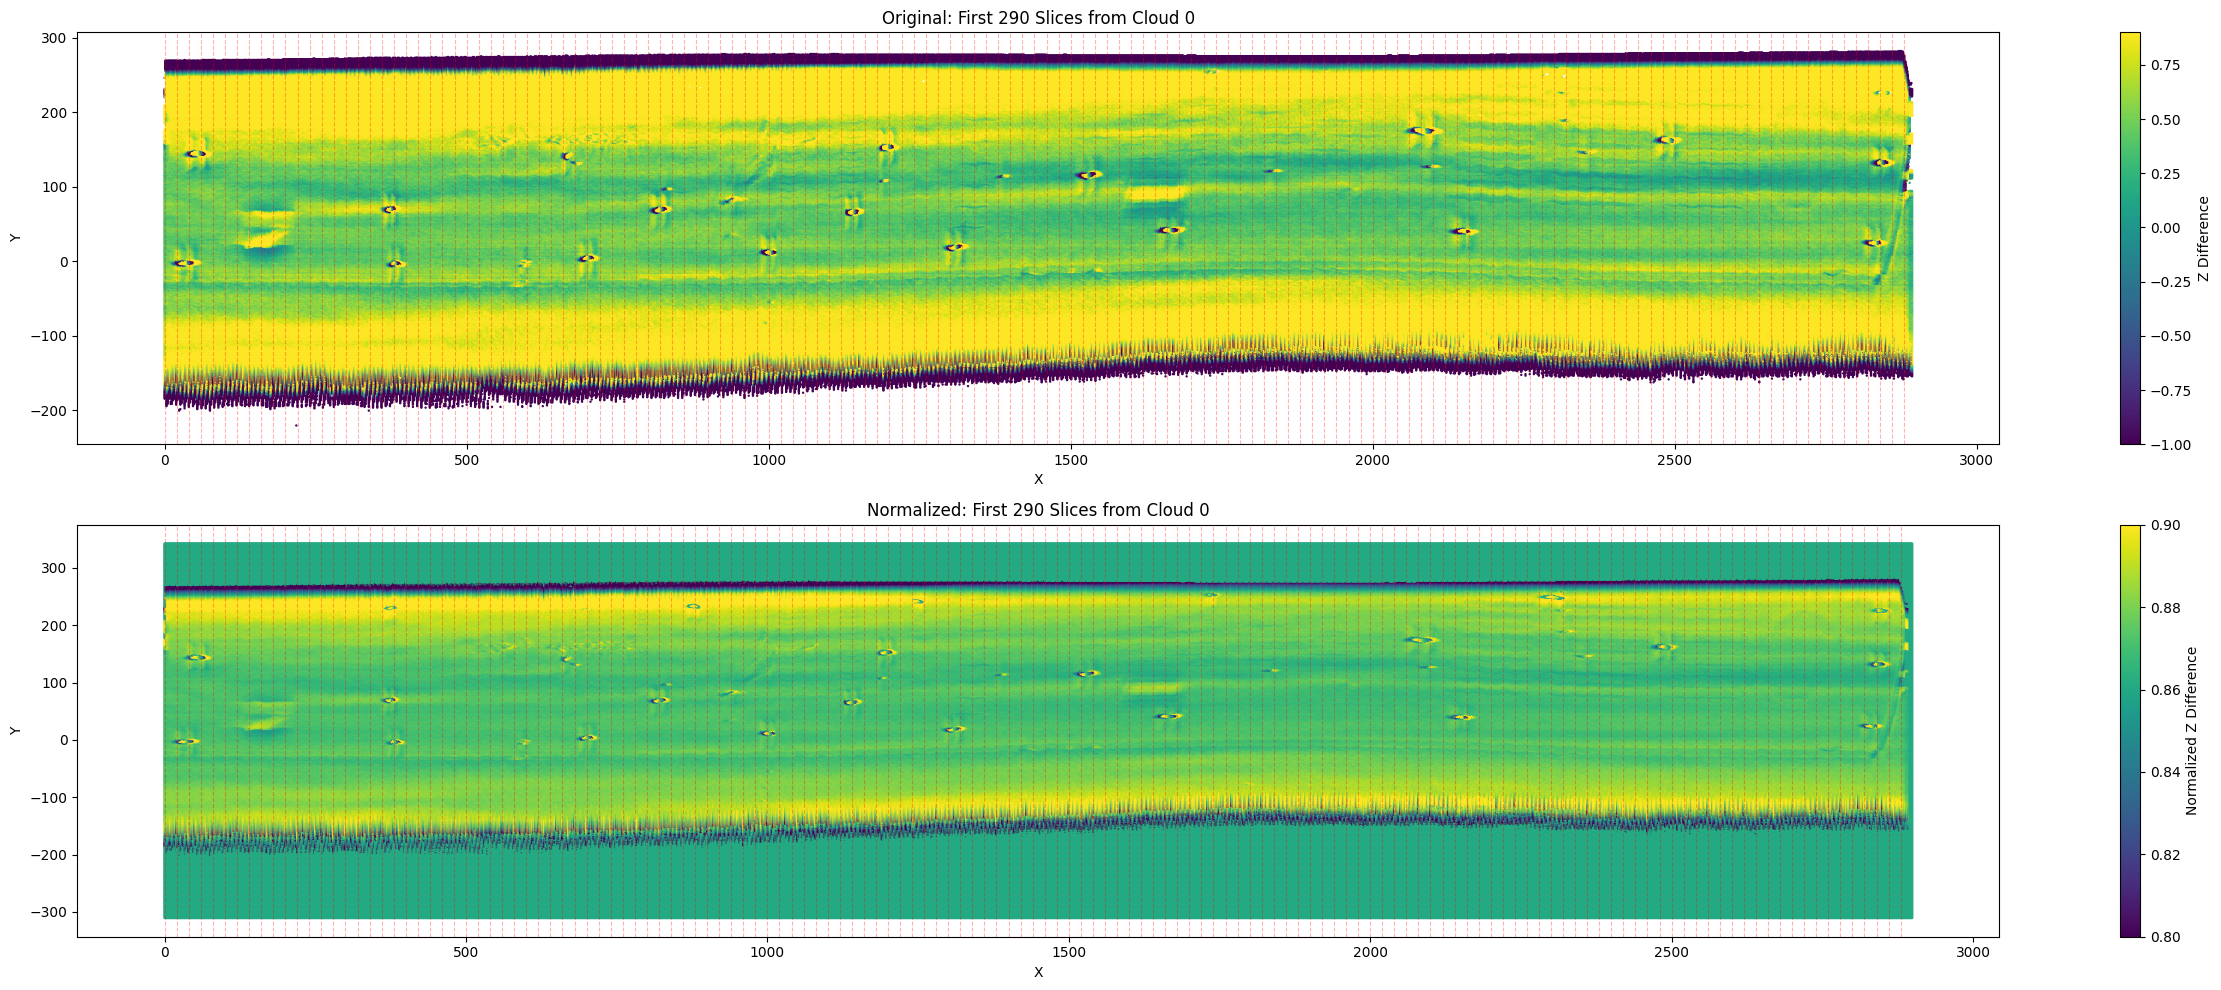

In [11]:
# Visualize normalized slices
fig, axes = plt.subplots(2, 1, figsize=(25, 10))

# Show first cloud: original vs normalized
cloud_idx = 0
images_original = all_image_slices[cloud_idx]
images_normalized = all_normalized_slices[cloud_idx]
starts = all_starts[cloud_idx]
slices_to_show = len(images_original)

for plot_idx, (images, title_prefix) in enumerate([(images_original, "Original"), (images_normalized, "Normalized")]):
    ax = axes[plot_idx]
    
    all_x = []
    all_y = []
    all_z = []
    
    for slice_idx in range(min(slices_to_show, len(images))):
        image = images[slice_idx]
        start_x = starts[slice_idx]
        
        # Convert image back to point cloud format for scatter plot
        y_coords, x_coords = np.where(image != 0)  # Get non-zero pixel coordinates
        z_values = image[y_coords, x_coords]  # Get corresponding Z values
        
        # Convert pixel coordinates back to actual coordinates
        actual_x = x_coords + start_x
        actual_y = y_coords + global_y_min
        
        if len(z_values) > 0:
            all_x.extend(actual_x)
            all_y.extend(actual_y)
            all_z.extend(z_values)
    
    if len(all_x) > 0:
        # Create scatter plot
        if plot_idx == 0:  # Original
            sc = ax.scatter(all_x, all_y, c=all_z, s=0.5, cmap='viridis', vmin=-1, vmax=0.9)
        else:  # Normalized
            sc = ax.scatter(all_x, all_y, c=all_z, s=0.5, cmap='viridis', vmin=0.8, vmax=0.9)
        
        # Add colorbar
        cbar = plt.colorbar(sc, ax=ax)
        cbar.set_label('Z Difference' if plot_idx == 0 else 'Normalized Z Difference')
        
        ax.set_title(f"{title_prefix}: First {min(slices_to_show, len(images))} Slices from Cloud {cloud_idx}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        
        # Add slice boundaries (every 2nd slice to avoid clutter)
        for slice_idx in range(0, min(slices_to_show, len(starts)), 2):
            x_boundary = starts[slice_idx]
            ax.axvline(x=x_boundary, color='red', linestyle='--', alpha=0.3, linewidth=0.8)
    else:
        ax.text(0.5, 0.5, 'No data in selected slices', 
               horizontalalignment='center', verticalalignment='center', 
               transform=ax.transAxes)
        ax.set_title(f"{title_prefix}: No data available")

plt.tight_layout()
plt.show()

In [9]:
# Save the CNN-ready data
# Create output directory for CNN slices
cnn_slices_dir = diff_dir.replace("difference", "cnn_slices")
os.makedirs(cnn_slices_dir, exist_ok=True)

# Save all CNN-ready slices
for cloud_idx, (images, fname) in enumerate(zip(all_normalized_slices, npy_files)):
    base_name = os.path.splitext(fname)[0]
    stacked = np.stack(images, axis=0)
    
    outname = f"{base_name}_cnn_slices.npy"
    outpath = os.path.join(cnn_slices_dir, outname)
    np.save(outpath, stacked)
    print(f"Saved: {outpath} with shape {stacked.shape}")

Saved: ../scandata/cnn_slices loess frac=0.20/221111_144114__binary_onlylines114378to117271 loess frac=0.2_difference_cnn_slices.npy with shape (290, 654, 10)
Saved: ../scandata/cnn_slices loess frac=0.20/221111_144114__binary_onlylines145900to148050 loess frac=0.2_difference_cnn_slices.npy with shape (216, 654, 10)
Saved: ../scandata/cnn_slices loess frac=0.20/221111_144114__binary_onlylines25660to28100 loess frac=0.2_difference_cnn_slices.npy with shape (245, 654, 10)
Saved: ../scandata/cnn_slices loess frac=0.20/221111_144114__binary_onlylines47178to50517 loess frac=0.2_difference_cnn_slices.npy with shape (334, 654, 10)
Saved: ../scandata/cnn_slices loess frac=0.20/221111_144114__binary_onlylines86841to90142 loess frac=0.2_difference_cnn_slices.npy with shape (331, 654, 10)
